### 11章 DL Pytorch版

 ### 必要ライブラリの導入

In [1]:
# 日本語化ライブラリ導入
!pip install japanize-matplotlib -qq
!pip install torchviz -qq
!pip install torchinfo -qq

In [2]:
# 共通事前処理

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# matplotlib日本語化対応
import japanize_matplotlib

# データフレーム表示用関数
from IPython.display import display

# pandasでの浮動小数点の表示精度
pd.options.display.float_format = '{:.2f}'.format

# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

### ライブラリ導入

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

### GPU操作

In [4]:

# GPUが利用可能かどうかのチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 利用可能な場合は"cuda:0"が出力される
print(device)

cuda:0


### データ準備

In [5]:
# ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    # 元データダウンロード先の指定
    root = data_root,
    # 訓練データか検証データか
    train = True,
    # 元データがない場合にダウンロードするか
    download = True)

 ### DataSetの定義

In [6]:
# データ変換用関数 Transforms
# (1) Imageをテンソル化
# (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
# (3) データのshapeを[1, 28, 28]から[784]に変換

# ライブラリインポート
import torchvision.transforms as transforms

transform = transforms.Compose([
    # (1) データのテンソル化
    transforms.ToTensor(),

    # (2) データの正規化
    transforms.Normalize(0.5, 0.5),

    # (3) 1階テンソルに変換
    transforms.Lambda(lambda x: x.view(-1)),
])

In [7]:
# データ取得用関数 Dataset

# 訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False,
    download = True, transform = transform)

In [8]:
# ライブラリインポート
from torch.utils.data import DataLoader

# ミニバッチのサイズ指定
batch_size = 128

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(
    test_set,  batch_size = batch_size,
    shuffle = False)

In [10]:
# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

torch.Size([128, 784])
torch.Size([128])


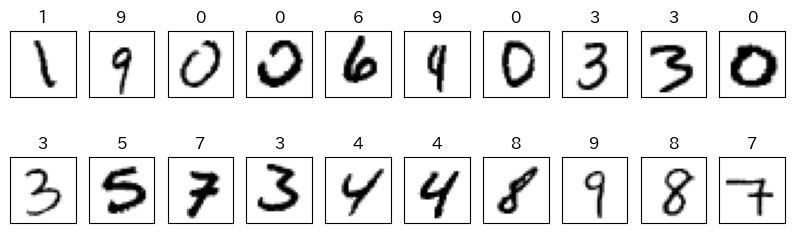

In [11]:
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    # numpyに変換
    image = images[i].numpy()
    label = labels[i]

    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
print(image.shape)

(784,)


### モデル定義

In [17]:
# 入力次元数
n_input = image.shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = 10

#   隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 128 n_output: 10


In [18]:
# モデルの定義
# 784入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### 繰り返し計算

In [21]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))

In [22]:
%%time
# tqdmライブラリのインポート
from tqdm.notebook import tqdm

# 繰り返し計算メインループ

for epoch in range(num_epochs):
    # 1エポックあたりの正解数(精度計算用)
    n_train_acc, n_val_acc = 0, 0
    # 1エポックあたりの累積損失(平均化前)
    train_loss, val_loss = 0, 0
    # 1エポックあたりのデータ累積件数
    n_train, n_test = 0, 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        # 1バッチあたりのデータ件数
        train_batch_size = len(labels)
        # 1エポックあたりのデータ累積件数
        n_train += train_batch_size

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)

        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()

        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        train_loss += loss.item() * train_batch_size
        n_train_acc += (predicted == labels).sum().item()

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        # 1バッチあたりのデータ件数
        test_batch_size = len(labels_test)
        # 1エポックあたりのデータ累積件数
        n_test += test_batch_size

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        #  平均前の損失と正解数の計算
        # lossは平均計算が行われているので平均前の損失に戻して加算
        val_loss +=  loss_test.item() * test_batch_size
        n_val_acc +=  (predicted_test == labels_test).sum().item()

    # 精度計算
    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_test
    # 損失計算
    ave_train_loss = train_loss / n_train
    ave_val_loss = val_loss / n_test
    # 結果表示
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f}')
    # 記録
    item = np.array([epoch+1 , ave_train_loss, train_acc, ave_val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/100], loss: 1.05294 acc: 0.76188


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/100], loss: 0.45637 acc: 0.87790


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/100], loss: 0.37962 acc: 0.89287


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/100], loss: 0.34657 acc: 0.90063


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/100], loss: 0.32605 acc: 0.90607


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/100], loss: 0.31060 acc: 0.91063


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/100], loss: 0.29843 acc: 0.91405


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/100], loss: 0.28757 acc: 0.91747


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/100], loss: 0.27767 acc: 0.91993


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/100], loss: 0.26816 acc: 0.92298


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/100], loss: 0.25932 acc: 0.92518


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [12/100], loss: 0.25078 acc: 0.92887


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [13/100], loss: 0.24272 acc: 0.93097


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [14/100], loss: 0.23505 acc: 0.93330


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [15/100], loss: 0.22738 acc: 0.93542


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [16/100], loss: 0.22045 acc: 0.93745


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [17/100], loss: 0.21362 acc: 0.93952


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [18/100], loss: 0.20723 acc: 0.94157


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [19/100], loss: 0.20089 acc: 0.94317


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [20/100], loss: 0.19542 acc: 0.94483


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [21/100], loss: 0.18973 acc: 0.94657


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [22/100], loss: 0.18441 acc: 0.94823


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [23/100], loss: 0.17957 acc: 0.95022


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [24/100], loss: 0.17478 acc: 0.95088


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [25/100], loss: 0.17045 acc: 0.95235


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [26/100], loss: 0.16617 acc: 0.95313


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [27/100], loss: 0.16228 acc: 0.95482


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [28/100], loss: 0.15842 acc: 0.95553


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [29/100], loss: 0.15482 acc: 0.95653


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [30/100], loss: 0.15130 acc: 0.95782


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [31/100], loss: 0.14762 acc: 0.95862


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [32/100], loss: 0.14466 acc: 0.95967


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [33/100], loss: 0.14152 acc: 0.96020


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [34/100], loss: 0.13850 acc: 0.96138


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [35/100], loss: 0.13577 acc: 0.96182


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [36/100], loss: 0.13296 acc: 0.96208


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [37/100], loss: 0.13022 acc: 0.96338


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [38/100], loss: 0.12765 acc: 0.96388


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [39/100], loss: 0.12497 acc: 0.96492


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [40/100], loss: 0.12283 acc: 0.96542


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [41/100], loss: 0.12028 acc: 0.96635


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [42/100], loss: 0.11819 acc: 0.96722


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [43/100], loss: 0.11617 acc: 0.96727


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [44/100], loss: 0.11420 acc: 0.96807


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [45/100], loss: 0.11209 acc: 0.96872


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [46/100], loss: 0.11010 acc: 0.96962


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [47/100], loss: 0.10831 acc: 0.96990


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [48/100], loss: 0.10669 acc: 0.97020


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [49/100], loss: 0.10485 acc: 0.97078


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [50/100], loss: 0.10305 acc: 0.97143


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [51/100], loss: 0.10118 acc: 0.97190


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [52/100], loss: 0.09959 acc: 0.97235


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [53/100], loss: 0.09802 acc: 0.97300


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [54/100], loss: 0.09673 acc: 0.97323


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [55/100], loss: 0.09513 acc: 0.97355


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [56/100], loss: 0.09347 acc: 0.97418


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [57/100], loss: 0.09224 acc: 0.97458


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [58/100], loss: 0.09093 acc: 0.97480


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [59/100], loss: 0.08972 acc: 0.97523


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [60/100], loss: 0.08829 acc: 0.97592


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [61/100], loss: 0.08713 acc: 0.97630


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [62/100], loss: 0.08583 acc: 0.97632


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [63/100], loss: 0.08468 acc: 0.97683


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [64/100], loss: 0.08349 acc: 0.97722


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [65/100], loss: 0.08220 acc: 0.97763


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [66/100], loss: 0.08108 acc: 0.97793


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [67/100], loss: 0.08005 acc: 0.97818


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [68/100], loss: 0.07893 acc: 0.97848


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [69/100], loss: 0.07812 acc: 0.97883


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [70/100], loss: 0.07690 acc: 0.97912


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [71/100], loss: 0.07589 acc: 0.97928


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [72/100], loss: 0.07479 acc: 0.97957


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [73/100], loss: 0.07401 acc: 0.97987


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [74/100], loss: 0.07307 acc: 0.98025


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [75/100], loss: 0.07206 acc: 0.98038


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [76/100], loss: 0.07126 acc: 0.98103


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [77/100], loss: 0.07032 acc: 0.98093


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [78/100], loss: 0.06948 acc: 0.98153


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [79/100], loss: 0.06846 acc: 0.98160


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [80/100], loss: 0.06774 acc: 0.98218


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [81/100], loss: 0.06694 acc: 0.98235


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [82/100], loss: 0.06619 acc: 0.98240


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [83/100], loss: 0.06530 acc: 0.98243


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [84/100], loss: 0.06447 acc: 0.98315


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [85/100], loss: 0.06367 acc: 0.98300


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [86/100], loss: 0.06290 acc: 0.98322


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [87/100], loss: 0.06228 acc: 0.98320


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [88/100], loss: 0.06161 acc: 0.98373


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [89/100], loss: 0.06088 acc: 0.98393


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [90/100], loss: 0.06012 acc: 0.98427


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [91/100], loss: 0.05947 acc: 0.98435


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [92/100], loss: 0.05876 acc: 0.98447


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [93/100], loss: 0.05818 acc: 0.98457


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [94/100], loss: 0.05745 acc: 0.98493


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [95/100], loss: 0.05694 acc: 0.98500


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [96/100], loss: 0.05623 acc: 0.98513


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [97/100], loss: 0.05557 acc: 0.98562


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [98/100], loss: 0.05506 acc: 0.98555


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [99/100], loss: 0.05426 acc: 0.98583


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [100/100], loss: 0.05371 acc: 0.98627
CPU times: user 23min 42s, sys: 13.6 s, total: 23min 55s
Wall time: 24min 44s


### 結果確認

In [23]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 0.51911 精度: 0.86990
最終状態: 損失: 0.08172 精度: 0.97520


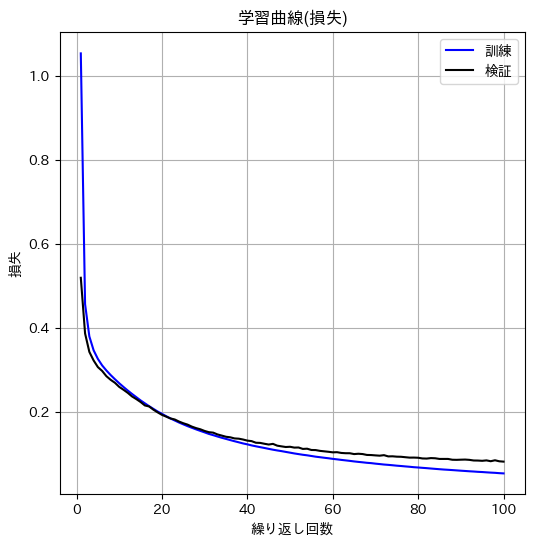

In [29]:
# 学習曲線の表示 (損失)

plt.rcParams['figure.figsize'] = (6,6)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid()
plt.legend()
plt.show()

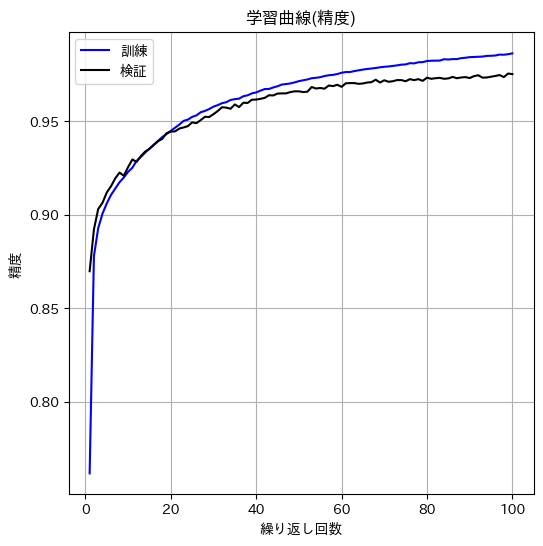

In [30]:
# 学習曲線の表示 (精度)

plt.rcParams['figure.figsize'] = (6,6)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.grid()
plt.legend()
plt.show()

In [31]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

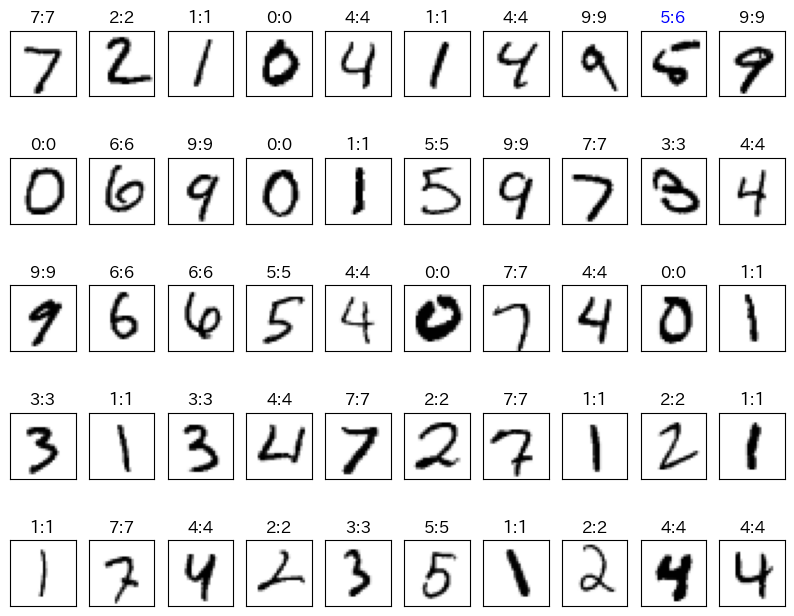

In [32]:
# 最初の50件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)

  # numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'

  # imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/ 2

  # イメージ表示
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


### バージョン確認

In [33]:
!pip install watermark -qq
%load_ext watermark
%watermark --iversions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.9 MB/s eta 0:00:00
japanize_matplotlib: 1.1.3
IPython            : 7.34.0
torch              : 2.5.1+cu121
torchviz           : 0.0.3
tqdm               : 4.67.1
pandas             : 2.2.2
torchvision        : 0.20.1+cu121
matplotlib         : 3.10.0
numpy              : 1.26.4
torchinfo          : 1.8.0

